In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import svm 
from scipy.io import loadmat
from mpl_toolkits.mplot3d import Axes3D
from time import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [2]:
"""Load the datasets."""
images = loadmat('images.mat') 
classes = loadmat('classes')

images=images['images'].T  
classes=classes['classes'].T

In [3]:
X_train, X_test, y_train, y_test = train_test_split(images, classes, test_size=0.3, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1689, 32256)
(1689, 1)
(725, 32256)
(725, 1)


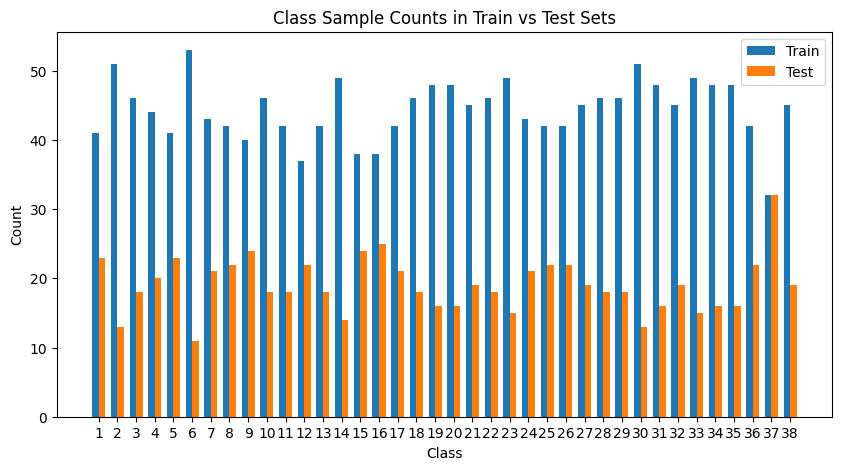

In [4]:
classes = np.unique(np.concatenate([y_train, y_test]))
counts_train = [np.sum(y_train == c) for c in classes]
counts_test  = [np.sum(y_test == c)  for c in classes]

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize = (10,5))
ax.bar(x - width/2, counts_train, width, label='Train')
ax.bar(x + width/2, counts_test, width, label='Test')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Sample Counts in Train vs Test Sets')
ax.legend()

plt.show()

In [5]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std  = scaler.transform(X_test)

In [6]:
n_samples, n_features = X_train_std.shape
n_classes = len(np.unique(y_train))

pca = PCA(n_components=n_samples - n_classes)
X_pca = pca.fit_transform(X_train_std)
W_pca = pca.components_.T

print("PCA shape:", X_pca.shape)

PCA shape: (1689, 1651)


In [24]:
mean_total = np.mean(X_pca, axis=0)
S_W = np.zeros((X_pca.shape[1], X_pca.shape[1]))
S_B = np.zeros_like(S_W)

for cls in np.unique(y_train):
    X_cls = X_pca[(y_train==cls).flatten(),:]
    mean_cls = np.mean(X_cls, axis=0)
    S_W += (X_cls - mean_cls).T @ (X_cls - mean_cls)
    n_cls = X_cls.shape[0]
    diff = (mean_cls - mean_total).reshape(-1, 1)
    S_B += n_cls * (diff @ diff.T)

In [25]:
eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(S_W) @ S_B)
idx = np.argsort(-eigvals.real)
eigvecs = eigvecs[:, idx]
W_fld = eigvecs[:, :n_classes - 1].real

print("FLD shape:", W_fld.shape)

FLD shape: (1651, 37)


In [26]:
W_fisher = W_pca @ W_fld  # shape: (n_features, n_classes - 1)
print("W_fisher shape:", W_fisher.shape)

W_fisher shape: (32256, 37)


In [27]:
X_train_fisher = X_train_std @ W_fisher
X_test_fisher  = X_test_std @ W_fisher

print("Projected Train:", X_train_fisher.shape)
print("Projected Test:", X_test_fisher.shape)

Projected Train: (1689, 37)
Projected Test: (725, 37)


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_fisher, y_train)

y_train_pred = clf.predict(X_train_fisher)
y_test_pred = clf.predict(X_test_fisher)

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_test, y_pred))

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_pred))

/opt/jlab-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train Accuracy: 0.9970396684428656
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        23
           2       0.81      1.00      0.90        13
           3       1.00      0.94      0.97        18
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        21
           8       1.00      1.00      1.00        22
           9       1.00      0.96      0.98        24
          10       1.00      0.94      0.97        18
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        22
          13       1.00      1.00      1.00        18
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        24
          16       1.00      0.96      0.98        25
          17       1.00      1.00      1.00   

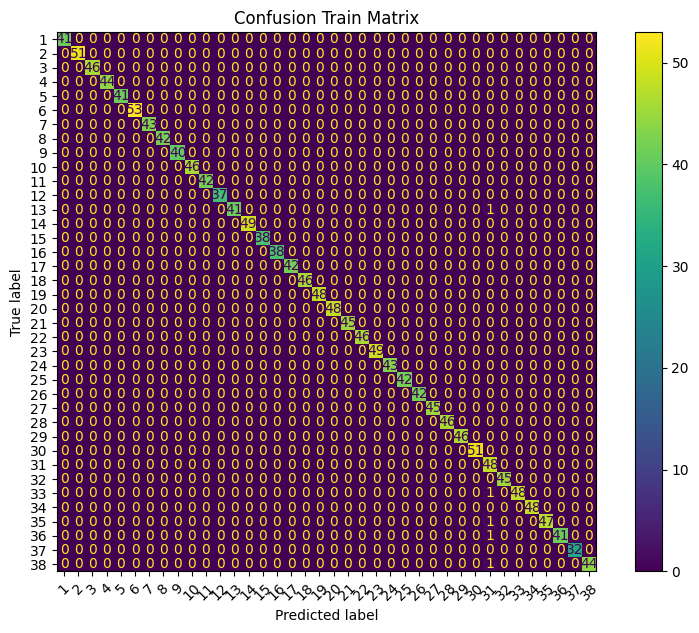

In [39]:
cm = confusion_matrix(y_train, y_train_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis', xticks_rotation=45)
disp.figure_.set_size_inches(10, 7)  # directly change the size
plt.title("Confusion Train Matrix")
plt.grid(False)
plt.show()

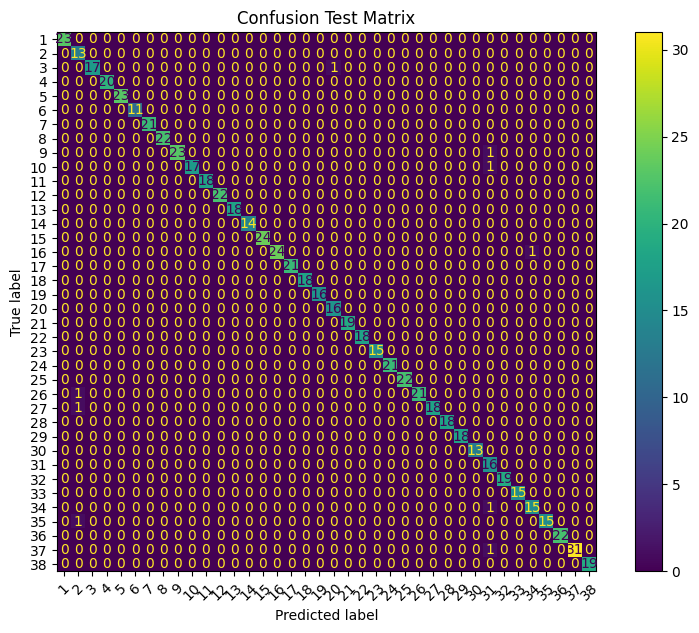

In [40]:
cm = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis', xticks_rotation=45)
disp.figure_.set_size_inches(10, 7)  # directly change the size
plt.title("Confusion Test Matrix")
plt.grid(False)
plt.show()

In [45]:
n_classes = len(np.unique(y_train))
Y_train_ova = np.zeros((X_train_fisher.shape[0], n_classes))

for idx, cls in enumerate(np.unique(y_train)):
    Y_train_ova[:, idx] = (y_train == cls).flatten().astype(float)

# Add bias column to X
X_aug = np.hstack([X_train_fisher, np.ones((X_train_fisher.shape[0], 1))])  # shape: (N, d+1)

# Solve for W: shape (d+1, n_classes)
W = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ Y_train_ova

In [52]:
X_test_aug = np.hstack([X_test_fisher, np.ones((X_test_fisher.shape[0], 1))])  # shape: (N_test, d+1)
Y_pred_scores = X_test_aug @ W  # shape: (N_test, n_classes)

y_pred = np.argmax(Y_pred_scores, axis=1) + 1

Accuracy: 0.9903448275862069
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        23
           2       0.93      1.00      0.96        13
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        21
           8       1.00      1.00      1.00        22
           9       1.00      0.96      0.98        24
          10       1.00      0.94      0.97        18
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        22
          13       1.00      1.00      1.00        18
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        24
          16       1.00      0.96      0.98        25
          17       1.00      1.00      1.00        2

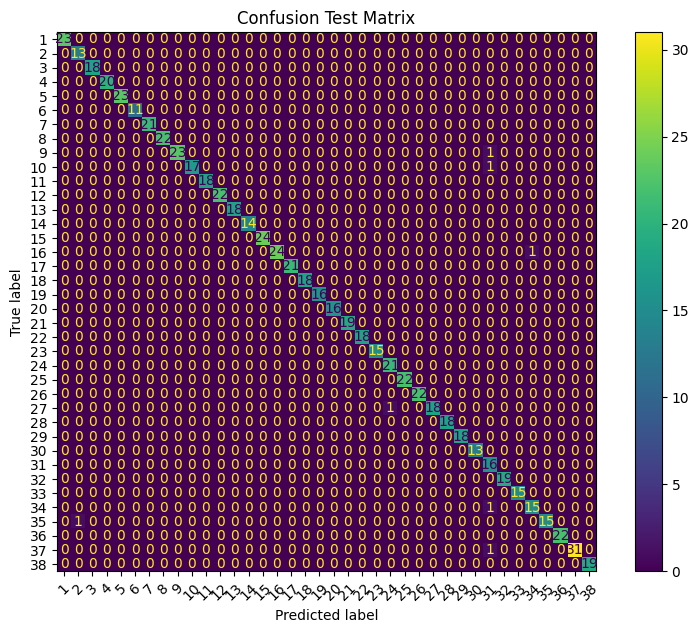

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='viridis', xticks_rotation=45)
disp.figure_.set_size_inches(10, 7)  # directly change the size
plt.title("Confusion Test Matrix")
plt.grid(False)
plt.show()